In [1]:
import tarfile
tar_file_path = "/content/transistor.tar"
with tarfile.open(tar_file_path) as tar:
  tar.extractall()

In [ ]:
!pip install onnx onnxruntime-gpu tqdm scipy scikit-image scikit-learn opencv-python-headless matplotlib

# **Training**

In [13]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import onnx
import cv2
from tqdm import tqdm

# CONFIGURATION
IMG_SIZE = (256, 256)
ARCH = "mobilenet_v3_small"
PRETRAINED = True
HOOK_MODULE_NAMES = ['features.1', 'features.3', 'features.8']
D_REDUCED = 100
SEED = 1024
BATCH_SIZE = 32
TRAIN_DIR = '/content/transistor/train/good'
RESULT_DIR = '/content/transistor_padim'
MODEL_FILENAME_ONNX = os.path.join(RESULT_DIR, f"{ARCH}_with_intermediates.onnx")
PADIM_PARAMS_FILENAME = os.path.join(RESULT_DIR, 'padim_params.npz')

os.makedirs(RESULT_DIR, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# DATASET
class TransistorDataset(Dataset):
    def __init__(self, root, transform=None):
        self.files = [os.path.join(root, f) for f in os.listdir(root) if f.endswith(('jpg', 'jpeg', 'png'))]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert('RGB')
        return self.transform(img) if self.transform else img

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_loader = DataLoader(TransistorDataset(TRAIN_DIR, transform), batch_size=BATCH_SIZE, shuffle=True)

# MODEL SETUP
model = models.mobilenet_v3_small(pretrained=PRETRAINED).to(device).eval()
outputs = {}

def get_hook(name):
    def hook(model, input, output):
        outputs[name] = output.detach()
    return hook

hooks = [module.register_forward_hook(get_hook(name))
         for name, module in model.named_modules() if name in HOOK_MODULE_NAMES]

with torch.no_grad():
    _ = model(torch.randn(1, 3, *IMG_SIZE).to(device))
feature_shapes = {name: outputs[name].shape for name in HOOK_MODULE_NAMES}
t_d = sum(shape[1] for shape in feature_shapes.values())
d = min(D_REDUCED, t_d)
idx = torch.tensor(random.sample(range(0, t_d), d))

# FEATURE EXTRACTION
train_features_list = [[] for _ in HOOK_MODULE_NAMES]
with torch.no_grad():
    for x in tqdm(train_loader, desc="Extracting Features"):
        x = x.to(device)
        _ = model(x)
        for i, name in enumerate(HOOK_MODULE_NAMES):
            train_features_list[i].append(outputs[name].cpu())

train_features = {name: torch.cat(train_features_list[i], dim=0) for i, name in enumerate(HOOK_MODULE_NAMES)}
target_shape = train_features[HOOK_MODULE_NAMES[0]].shape[2:]
resized_features = [F.interpolate(train_features[name].float(), size=target_shape, mode='bilinear', align_corners=False)
                    for name in HOOK_MODULE_NAMES]
embedding_vectors = torch.cat(resized_features, dim=1)
embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

# STATISTICS
N, C, H, W = embedding_vectors.size()
emb_np = embedding_vectors.view(N, C, H * W).numpy()
mean_vec = np.mean(emb_np, axis=0)
inv_cov = np.zeros((C, C, H * W))
identity = np.identity(C)
for i in tqdm(range(H * W), desc="Covariance"):
    cov = np.cov(emb_np[:, :, i], rowvar=False) + 0.01 * identity
    inv_cov[:, :, i] = np.linalg.pinv(cov)

np.savez(PADIM_PARAMS_FILENAME, mean=mean_vec, inv_covariance=inv_cov, idx=idx.numpy(),
         img_size=np.array(IMG_SIZE), feature_map_shape=np.array([H, W]),
         normalization_mean=np.array([0.485, 0.456, 0.406]),
         normalization_std=np.array([0.229, 0.224, 0.225]),
         hook_module_names=np.array(HOOK_MODULE_NAMES))

for h in hooks: h.remove()
del model

# ONNX EXPORT
class ModelWithIntermediateOutputs(nn.Module):
    def __init__(self, model, output_layers):
        super().__init__()
        self.model = model
        self.output_layers = output_layers
        self.outputs = {}
        for name, module in self.model.named_modules():
            if name in self.output_layers:
                module.register_forward_hook(self._save_hook(name))

    def _save_hook(self, name):
        def hook(module, input, output):
            self.outputs[name] = output
        return hook

    def forward(self, x):
        self.outputs.clear()
        final_output = self.model(x)
        return final_output, *[self.outputs[name] for name in self.output_layers]

export_model = ModelWithIntermediateOutputs(models.mobilenet_v3_small(pretrained=PRETRAINED).to(device).eval(), HOOK_MODULE_NAMES)
torch.onnx.export(export_model, torch.randn(1, 3, *IMG_SIZE).to(device), MODEL_FILENAME_ONNX,
                  export_params=True, opset_version=12, do_constant_folding=True,
                  input_names=["input_image"],
                  output_names=["final_classifier_output"] + ['intermediate_features_1', 'intermediate_features_3', 'intermediate_features_8'],
                  dynamic_axes={"input_image": {0: "batch_size"}})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Covariance: 100%|██████████| 4096/4096 [00:15<00:00, 266.52it/s]


# **Testing**

In [19]:
import onnxruntime
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

RESULT_DIR = '/content/transistor_padim'
MODEL_FILENAME_ONNX = os.path.join(RESULT_DIR, f"{ARCH}_with_intermediates.onnx")
PADIM_PARAMS_FILENAME = os.path.join(RESULT_DIR, 'padim_params.npz')
TEST_DIR = '/content/transistor/test/bent_lead'
VISUALIZATION_DIR = os.path.join(RESULT_DIR, 'visualizations')
os.makedirs(VISUALIZATION_DIR, exist_ok=True)

ONNX_OUTPUT_NAMES = ['intermediate_features_1', 'intermediate_features_3', 'intermediate_features_8']
SCORE_THRESHOLD_PCT = 98

session = onnxruntime.InferenceSession(MODEL_FILENAME_ONNX, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
input_name = session.get_inputs()[0].name

params = np.load(PADIM_PARAMS_FILENAME)
mean_vec = params['mean']
inv_cov = params['inv_covariance']
idx = params['idx']
img_size = tuple(params['img_size'])
feature_shape = tuple(params['feature_map_shape'])
norm_mean = params['normalization_mean']
norm_std = params['normalization_std']

image_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith(('jpg', 'jpeg', 'png'))]

for i, path in enumerate(tqdm(image_files, desc="Testing")):
    img = Image.open(path).convert('RGB').resize(img_size)
    img_np = np.array(img).astype(np.float32) / 255.0
    img_norm = (img_np - norm_mean) / norm_std
    input_tensor = np.expand_dims(img_norm.transpose(2, 0, 1), axis=0).astype(np.float32)

    outputs = session.run(ONNX_OUTPUT_NAMES, {input_name: input_tensor})
    resized = [cv2.resize(out[0].transpose(1, 2, 0), feature_shape[::-1], interpolation=cv2.INTER_LINEAR).transpose(2, 0, 1)
               for out in outputs]
    embedding = np.concatenate(resized, axis=0)[idx]
    embedding_flat = embedding.reshape(len(idx), -1)
    dist_map = np.zeros(embedding_flat.shape[1])

    for j in range(embedding_flat.shape[1]):
        dist_map[j] = mahalanobis(embedding_flat[:, j], mean_vec[:, j], inv_cov[:, :, j])

    dist_map = dist_map.reshape(feature_shape)
    dist_map = gaussian_filter(cv2.resize(dist_map, img_size), sigma=4)

    threshold = np.percentile(dist_map, SCORE_THRESHOLD_PCT)
    mask = (dist_map > threshold).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    heatmap = cv2.applyColorMap((255 * (dist_map - dist_map.min()) / (dist_map.max() - dist_map.min())).astype(np.uint8), cv2.COLORMAP_JET)
    img_uint8 = np.array(img).astype(np.uint8)
    overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)
    vis = np.hstack([img_uint8, heatmap, cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR), overlay])
    cv2.imwrite(os.path.join(VISUALIZATION_DIR, f"result_{i:03d}.png"), vis)

print("\n--- Complete ---")

Testing: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


--- Complete ---


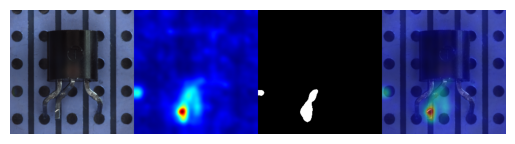

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/transistor_padim/visualizations/result_001.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
